# **Balancing Act: Mastering the Inverted Double Pendulum with Soft Actor-Critic**

The inverted double pendulum stands as a classic benchmark in control theory, celebrated for its inherent instability and nonlinear dynamics. This project explores the challenge of stabilizing this system using the Soft Actor-Critic (SAC) algorithm, a state-of-the-art reinforcement learning method, within the MuJoCo physics engine. SAC is an **actor-critic** algorithm, which means it uses two key components:

- **Actor**: The policy ($\pi(a|s)$), which decides what actions to take.
- **Critic**: A value function (like the Q-function, $Q(s,a)$), which evaluates how good those actions are.

SAC excels here because it balances reward maximization with **entropy regularization**, promoting exploration and robustness:

- **Exploration**: More entropy means the agent tries a wider variety of actions, helping it discover better strategies.
- **Robustness**: It prevents the policy from overfitting to one specific action, making it more adaptable.

## **Important Libraries**

### **Install**

In [ ]:
!apt -qq update
!apt -qq install -y libgl1-mesa-dev libglfw3

31 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglvnd-core-dev libglvnd-dev
  libglx-dev libopengl-dev
Suggested packages:
  libosmesa6 libvulkan1
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglfw3
  libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev
0 upgraded, 10 newly installed, 0 to remove and 31 not upgraded.
Need to get 304 kB of archives.
After this operation, 2,890 kB of additional disk space will be used.
Selecting previously unselected package libglx-dev:amd64.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../0-libglx-dev_1.4.0-1_amd64.deb ...
Unpacking li

In [ ]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.6.14 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [ ]:
# https://github.com/astral-sh/uv/issues/12724
!mkdir /backend-container
!mkdir /backend-container/containers
!touch /backend-container/containers/build.constraints
!touch /backend-container/containers/requirements.constraints

In [ ]:
try:
    !uv pip install -q --no-cache-dir --system lightning pyvirtualdisplay
    import lightning
    !uv pip install -q --no-cache-dir --system mujoco gymnasium[mujoco]
    import gymnasium
    !uv pip install -q --no-cache-dir --system pybullet moviepy
    import moviepy
    del lightning, gymnasium, moviepy
except Exception as e:
    print(e)
    !pip install -q --no-cache-dir lightning pyvirtualdisplay
    !pip install -q --no-cache-dir mujoco gymnasium[mujoco]
    !pip install -q --no-cache-dir pybullet moviepy
%env MUJOCO_GL=egl

error: a value is required for '--prerelease <PRERELEASE>' but none was supplied
  [possible values: disallow, allow, if-necessary, explicit, if-necessary-or-explicit]

For more information, try '--help'.
No module named 'lightning'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 220.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 210.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 224.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 300.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 241.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 193.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 178.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 188.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### **Import**

In [ ]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

import gymnasium as gym
import matplotlib.animation
import pybullet_envs
import pybullet as p
import glob

from enum import Enum
from datetime import datetime
from google.colab.patches import cv2_imshow
from collections import deque
from IPython.display import Image, HTML
from moviepy.editor import VideoFileClip
from base64 import b64encode

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from torch.distributions import Normal

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: DeprecationWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
  from scipy.ndimage.filters import sobel

  if event.key is 'enter':

  from pkg_resources import resource_stream, resource_exists

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)

Implementing implicit namespace packages (as specified in PEP

## **Configuration**

In [ ]:
''' https://gymnasium.farama.org/environments/mujoco/inverted_double_pendulum/ '''
ENVIRONMENT_NAME = "InvertedDoublePendulum-v5"
OBSERVATION_SPACE = 9
ACTION_SPACE = 1
MAX_ACTION = 1.0
LOG_THRESHOLD = int(1e2)
MAXIMUM_STEP_PER_EPISODE = int(1e3)
MAXIMUM_STEP = int(1e5)
RANDOM_EXPLORATION = 128
HIDDEN_DIM = 256

CONFIG = {
    f"{ENVIRONMENT_NAME.split('-')[0]}Agent": None,
    "TotalReward": 0,
    "BestAverageReward": -np.inf,
    "WriteLog": False,
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

REWARD_BUFFER = 160
BUFFER_SIZE = 2048

GAMMA = 0.99
TAU = 5e-3
ALPHA = 0.2

BATCH_SIZE = 256
LR = 3e-4

In [ ]:
EXPERIMENT_DIR = "experiment"
TRAINING_DIR = os.path.join(EXPERIMENT_DIR, "training")
DATASET_DIR = os.path.join(EXPERIMENT_DIR, "dataset")
MODEL_DIR = os.path.join(EXPERIMENT_DIR, "model")

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
os.makedirs(TRAINING_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(
    MODEL_DIR,
    f"{ENVIRONMENT_NAME.split('-')[0]}_best.ckpt",
)

In [ ]:
METRIC_TO_MONITOR = "reward"
METRIC_MODE = "max"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1480366005


In [ ]:
p.connect(p.DIRECT)

0

## **Dataset**

``InvertedDoublePendulum-v5`` is a physics-based simulation environment where the task is to stabilize an inverted double pendulum. It's part of the MuJoCo (Multi-Joint dynamics with Contact) suite, integrated into Gymnasium, and is a standard benchmark for testing reinforcement learning algorithms on complex, continuous control problems. Using SAC, the agent learns to map the 9D observations to 1D actions, optimizing the policy to maximize cumulative reward. The action space is continuous and bounded (i.e., $[-1, 1]$). An action represents the numerical force applied to the cart (with magnitude representing the amount of force and sign representing the direction). For more information, go to [here](https://gymnasium.farama.org/environments/mujoco/inverted_double_pendulum).

In [ ]:
class EpisodeStatus(Enum):
    RESET = 1
    RUNNING = 2

In [ ]:
class RLDataset(data.Dataset):
    def __init__(self, rl_agent, replay_buffer):
        super().__init__()

        global CONFIG

        CONFIG["CurrentEpisode"] = 0
        CONFIG["WriteLog"] = False

        self.rl_agent = rl_agent
        self.replay_buffer = replay_buffer

        self.env = None
        self.obs = None
        self.episode_status = EpisodeStatus.RESET
        self.current_step = 0
        self.done = False

    def __len__(self):
        return 1

    def reset_episode(self):
        global CONFIG

        CONFIG["TotalReward"] = 0
        self.current_step = 0
        self.done = False

        if (CONFIG["CurrentEpisode"] % LOG_THRESHOLD == 0):
            self.env = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")
            self.env = gym.wrappers.RecordVideo(
                self.env,
                video_folder=TRAINING_DIR,
                episode_trigger=lambda t: t % 10 == 0,
                disable_logger=True,
                name_prefix=(
                    f"{str(CONFIG['CurrentEpisode']).zfill(4)}-"
                    f"{ENVIRONMENT_NAME}"
                ),
            )
        else:
            self.env = gym.make(ENVIRONMENT_NAME)

        self.obs, _ = self.env.reset()

    @torch.no_grad()
    def collect_one_observation(self):
        global CONFIG

        state = torch.FloatTensor(self.obs).unsqueeze(0).to(DEVICE)
        if (CONFIG["CurrentEpisode"] < RANDOM_EXPLORATION):
            action = self.env.action_space.sample()
        else:
            action = self.rl_agent(state)
        (
            next_obs,
            reward,
            terminated,
            truncated,
            _
        ) = self.env.step(action)
        done = float(terminated or truncated)
        self.replay_buffer.add(self.obs, action, reward, next_obs, done)
        self.obs = next_obs
        CONFIG["TotalReward"] += reward
        self.current_step += 1
        self.done = bool(int(done))

        if self.done or self.current_step >= MAXIMUM_STEP_PER_EPISODE:
            self.env.close()
            del self.env
            self.episode_status = EpisodeStatus.RESET
            CONFIG["CurrentEpisode"] += 1

    def __getitem__(self, idx):
        global CONFIG

        if self.episode_status == EpisodeStatus.RESET:
            if (CONFIG["CurrentEpisode"] % LOG_THRESHOLD == 0):
                print(
                    f"Current episode: {CONFIG['CurrentEpisode']} - "
                    f"Total reward: {round(CONFIG['TotalReward'], 3)} - "
                    f"Total step: {self.current_step} - "
                    "Best average reward: "
                    f"{round(CONFIG['BestAverageReward'], 3)} - "
                    f"{datetime.now().strftime('%H:%M:%S')}"
                )
            self.replay_buffer.check_and_keep_episode(self.current_step)
            self.reset_episode()
            self.episode_status = EpisodeStatus.RUNNING

        self.collect_one_observation()

        if self.episode_status == EpisodeStatus.RESET:
            CONFIG["WriteLog"] = True
        else:
            CONFIG["WriteLog"] = False

        return self.replay_buffer.sample()

In [ ]:
class RLDataModule(L.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.dataset = RLDataset
        self.rl_agent = None

    def prepare_data(self):
        global CONFIG
        self.rl_agent = CONFIG[f"{ENVIRONMENT_NAME.split('-')[0]}Agent"]
        self.replay_buffer = ReplayBuffer()

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = self.dataset(
                rl_agent=self.rl_agent,
                replay_buffer=self.replay_buffer,
            )

    def train_dataloader(self):
        return data.DataLoader(self.train_dataset, batch_size=BATCH_SIZE)

## **Model**

### **Experience Replay Buffer**

The replay buffer stores transitions (state, action, reward, next_state, done) for training stability. It stores past experiences (state, action, reward, next_state, done) in a buffer and samples them randomly for training, improving efficiency and breaking correlation in data.

In [ ]:
class ReplayBuffer(object):
    def __init__(self):
        self.buffer = deque(maxlen=BUFFER_SIZE)
        self.reward_history = deque(maxlen=REWARD_BUFFER)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def check_and_keep_episode(self, step_size):
        """
        Add a transition to the buffer. Only the transition that is better from
        the best average is kept.
        """
        global CONFIG

        std_reward = np.array(
            self.reward_history
        ).std() if len(self.reward_history) > 0 else 0
        std_reward *= (GAMMA ** len(self.buffer))

        if CONFIG['TotalReward'] > (CONFIG['BestAverageReward'] - std_reward):
            self.reward_history.append(CONFIG['TotalReward'])
            reward_history = np.array(self.reward_history)
            CONFIG['BestAverageReward'] = reward_history.mean()
            random.shuffle(self.buffer)
        else:
            for _ in range(step_size):
                self.buffer.pop()

    def sample(self):
        """
        Sample a batch of transitions from the buffer.
        """
        if (len(self.buffer) < BATCH_SIZE):
            return (
                torch.FloatTensor(torch.zeros(0)).to(DEVICE),
                torch.FloatTensor(torch.zeros(0)).to(DEVICE),
                torch.FloatTensor(torch.zeros(0)).to(DEVICE),
                torch.FloatTensor(torch.zeros(0)).to(DEVICE),
                torch.FloatTensor(torch.zeros(0)).to(DEVICE)
            )
        batch = random.sample(self.buffer, BATCH_SIZE)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(state).to(DEVICE),
            torch.FloatTensor(action).to(DEVICE),
            torch.FloatTensor(reward).to(DEVICE),
            torch.FloatTensor(next_state).to(DEVICE),
            torch.FloatTensor(done).to(DEVICE)
        )

    def __len__(self):
        return len(self.buffer)

### **Actor Network**

- The policy ($\pi_\phi(a | s)$) is modeled as a Gaussian distribution, with a neural network outputting the mean and standard deviation.
- The actor is trained to maximize:
  $
  J(\phi) = \mathbb{E}_{s} \left[ \mathbb{E}_{a \sim \pi_\phi} \left[ \min_{i=1,2} Q_{\theta_i}(s, a) - \alpha \log \pi_\phi(a | s) \right] \right]
  $
- A trick called **reparameterization** (e.g., $a = \tanh(\mu + \sigma \epsilon) $) makes this trainable via backpropagation.
- **Entropy Temperature $\alpha$** balances reward and entropy. It can be fixed or learned adaptively, depending on the implementation.
- The optimal policy in maximum entropy RL is tied to the soft Q-function:
$
\pi^*(a | s) \propto \exp \left( \frac{1}{\alpha} Q^*(s, a) \right)
$. This means the policy favors actions with higher Q-values but keeps some randomness due to the exponential form. For continuous action spaces (like in robotics), computing this exactly is tricky, so SAC uses a neural network to approximate the policy and trains it to match this distribution.

In [ ]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.policy = nn.Sequential(
            nn.Linear(OBSERVATION_SPACE, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, ACTION_SPACE * 2)  # Mean and log_std
        )

    def forward(self, state, deterministic=False):
        output = self.policy(state)
        mean, log_std = output.chunk(2, dim=-1)
        log_std = torch.clamp(log_std, min=-20, max=2)  # Stabilize training
        std = log_std.exp()

        if deterministic:
            return MAX_ACTION * torch.tanh(mean)

        # Reparameterization trick for sampling
        dist = torch.distributions.Normal(mean, std)
        # Sample with reparameterization:
        #     By using rsample, we can backpropagate, because it keeps the
        #     computation graph alive.
        # https://stackoverflow.com/questions/60533150/what-is-the-difference-between-sample-and-rsample
        z = dist.rsample()
        action = torch.tanh(z)  # Squash to [-1, 1]
        log_prob = (
            dist.log_prob(z)
            - torch.log(1 - action.pow(2) + 1e-6) # Adjust for tanh
        )
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return MAX_ACTION * action, log_prob

### **Critic Network**

- SAC uses two Q-networks $(Q_{\theta_1}, Q_{\theta_2})$ to estimate the soft Q-function.
- Why two? To reduce **overestimation bias**, a problem where Q-values get inflated. SAC takes the minimum of the two Q-values for stability.
- To keep training stable, SAC uses **target Q-networks** $(Q_{\bar{\theta}_1}, Q_{\bar{\theta}_2})$, which are updated slowly using Polyak averaging:
  $
  \bar{\theta}_i \leftarrow \tau \theta_i + (1 - \tau) \bar{\theta}_i
  $. Here, $\tau$ is a small number (e.g., $0.005$), ensuring gradual updates.
- In SAC, the Q-function is adjusted to include entropy, becoming the **soft Q-function**:
$
Q^\pi(s_t, a_t) = r(s_t, a_t) + \gamma \mathbb{E}_{s_{t+1} \sim p} \left[ \mathbb{E}_{a_{t+1} \sim \pi} \left[ Q^\pi(s_{t+1}, a_{t+1}) - \alpha \log \pi(a_{t+1} | s_{t+1}) \right] \right]
$. This is the **soft Bellman equation**. It says the value of an action includes the immediate reward plus the expected future value, adjusted for the policy's entropy. The $-\alpha \log \pi$ term rewards actions that align with a more entropic (diverse) policy.

In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_value = nn.Sequential(
            nn.Linear(OBSERVATION_SPACE + ACTION_SPACE, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, 1)  # Output Q-value
        )

    def forward(self, state, action):
        """Compute Q-value for state-action pair."""
        x = torch.cat([state, action], dim=-1)
        return self.q_value(x)

### **Agent**

SAC is an **off-policy** algorithm, meaning it learns from past experiences stored in a replay buffer. The steps are:
1. **Collect Data**: Use the current policy (with some noise) to interact with the environment.
2. **Store Transitions**: Save $(s, a, r, s', d)$ in the buffer, where $d$ is a done flag.
3. **Sample a Batch**: Pull random experiences from the buffer.
4. **Update Critics**: Minimize the soft Bellman error:
   $
   \mathcal{L}(\theta_i) = \mathbb{E} \left[ \left( Q_{\theta_i}(s, a) - \left( r + \gamma (1 - d) \left( \min_{j=1,2} Q_{\bar{\theta}_j}(s', a') - \alpha \log \pi_\phi(a' | s') \right) \right) \right)^2 \right]
   $
5. **Update Actor**: Maximize the policy objective.
6. **Soft Update Targets**: Gradually update the target Q-networks.


In [ ]:
class AgentModule(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.actor = Actor()
        self.critic1 = Critic()
        self.critic2 = Critic()
        self.critic1_target = Critic()
        self.critic2_target = Critic()

        # Sync target networks
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        for param in self.critic1_target.parameters():
            param.requires_grad = False
        for param in self.critic2_target.parameters():
            param.requires_grad = False

        self.automatic_optimization = False

        self.reward = list()
        self.best_average_reward = list()

    def forward(self, state, deterministic=True):
        assert state.shape[0] == 1, "Batch size must be 1"
        action = self.actor_network(
            state,
            deterministic=deterministic,
        )
        return action.cpu().detach().numpy()[0]

    def actor_network(self, state, target=False, deterministic=False):
        if target:
            return self.actor_target(state, deterministic)
        return self.actor(state, deterministic)

    def critic_network(self, id, state, action, target=False):
        if target:
            if id == 1:
                return self.critic1_target(state, action)
            elif id == 2:
                return self.critic2_target(state, action)

            raise ValueError(f"Invalid id: {id}")

        if id == 1:
            return self.critic1(state, action)
        elif id == 2:
            return self.critic2(state, action)

        raise ValueError(f"Invalid id: {id}")

    def training_step(self, batch, batch_nb):
        global CONFIG
        state, action, reward, next_state, done = batch

        state = state.squeeze(0)
        action = action.squeeze(0)
        reward = reward.squeeze(0).unsqueeze(1)
        next_state = next_state.squeeze(0)
        done = done.squeeze(0).unsqueeze(1)

        if (
            state.sum()
            + action.sum()
            + reward.sum()
            + next_state.sum()
            + done.sum()
         ) != 0:

            # Critic update
            with torch.no_grad():
                next_action, next_log_prob = self.actor_network(next_state)
                target_q1 = self.critic_network(
                    1, next_state, next_action, target=True
                )
                target_q2 = self.critic_network(
                    2, next_state, next_action, target=True
                )
                target_q = (
                    torch.min(target_q1, target_q2)
                    - ALPHA * next_log_prob
                )
                target_q = reward + (1 - done) * GAMMA * target_q

            current_q1 = self.critic_network(1, state, action)
            current_q2 = self.critic_network(2, state, action)
            critic1_loss = F.mse_loss(current_q1, target_q)
            critic2_loss = F.mse_loss(current_q2, target_q)

            optimizer = self.optimizers()[0]
            optimizer.zero_grad()
            self.manual_backward(critic1_loss)
            optimizer.step()

            optimizer = self.optimizers()[1]
            optimizer.zero_grad()
            self.manual_backward(critic2_loss)
            optimizer.step()

            # Actor update
            action_new, log_prob = self.actor_network(state)
            q1_new = self.critic_network(1, state, action_new)
            q2_new = self.critic_network(2, state, action_new)
            q_new = torch.min(q1_new, q2_new)
            actor_loss = (ALPHA * log_prob - q_new).mean()

            optimizer = self.optimizers()[2]
            optimizer.zero_grad()
            self.manual_backward(actor_loss)
            optimizer.step()

            # Soft update target networks
            for param, target_param in zip(
                self.critic1.parameters(), self.critic1_target.parameters()
            ):
                target_param.data.copy_(
                    TAU * param.data + (1 - TAU) * target_param.data
                )

            for param, target_param in zip(
                self.critic2.parameters(), self.critic2_target.parameters()
            ):
                target_param.data.copy_(
                    TAU * param.data + (1 - TAU) * target_param.data
                )

        if CONFIG['WriteLog']:
            self.log("reward", CONFIG['TotalReward'], prog_bar=True)
            self.log(
                "best_average_reward", CONFIG['BestAverageReward'],
                prog_bar=True
            )
            self.reward.append(CONFIG['TotalReward'])
            self.best_average_reward.append(CONFIG['BestAverageReward'])

    def on_train_epoch_end(self):
        global CONFIG
        if CONFIG['CurrentEpisode'] % LOG_THRESHOLD == 0:
            self.reward_curve(False)

    def configure_optimizers(self):
        optimizer_critic1 = optim.Adam(self.critic1.parameters(), lr=LR)
        optimizer_critic2 = optim.Adam(self.critic2.parameters(), lr=LR)
        optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR)
        return [
            optimizer_critic1,
            optimizer_critic2,
            optimizer_actor
        ], []

    def reward_curve(self, show=True):
        filename = os.path.join(EXPERIMENT_DIR, "reward_curve.png")
        plt.plot(self.reward, color="g")
        plt.plot(self.best_average_reward, color="b")
        plt.title("Reward Curves")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.grid()
        plt.savefig(filename)
        plt.clf()
        if show:
            img = cv2.imread(filename)
            cv2_imshow(img)

## **Training**

In [ ]:
trainer = None

def _train_loop():
    global CONFIG, trainer

    seed_everything(SEED, workers=True)

    CONFIG[f"{ENVIRONMENT_NAME.split('-')[0]}Agent"] = AgentModule()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=MODEL_DIR,
        mode=METRIC_MODE,
        filename=f"{ENVIRONMENT_NAME.split('-')[0]}_best",
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAXIMUM_STEP,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )

    trainer.fit(
        CONFIG[f"{ENVIRONMENT_NAME.split('-')[0]}Agent"],
        ckpt_path=ckpt_path,
        datamodule=RLDataModule()
    )

_train_loop()

INFO: Seed set to 1480366005
INFO:lightning.fabric.utilities.seed:Seed set to 1480366005
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type   | Params | Mode 
--------------------------------------------------
0 | actor          | Actor  | 68.9 K | train
1 | critic1        | Critic | 68.9 K | train
2 | critic2        | Critic | 68.9 K | train
3 | critic1_target | Critic | 68.9 K | train
4 | critic2_target | Critic | 68.9 K | train
--------------------------------------------------
206 K     Trainable params
137 K     Non-trainable params
344 K     Total params
1.377     Total estimated model params size (MB)
35        Modules in train mode
0

Training: |          | 0/? [00:00<?, ?it/s]

Current episode: 0 - Total reward: 0 - Total step: 0 - Best average reward: -inf - 04:52:14
Current episode: 100 - Total reward: 44.437 - Total step: 6 - Best average reward: 65.837 - 04:52:49
Current episode: 200 - Total reward: 101.211 - Total step: 12 - Best average reward: 105.224 - 04:53:48
Current episode: 300 - Total reward: 315.087 - Total step: 35 - Best average reward: 214.358 - 04:56:22
Current episode: 400 - Total reward: 1045.25 - Total step: 113 - Best average reward: 401.999 - 05:00:46
Current episode: 500 - Total reward: 72.527 - Total step: 9 - Best average reward: 1076.644 - 05:13:11
Current episode: 600 - Total reward: 296.569 - Total step: 33 - Best average reward: 1112.669 - 05:16:52
Current episode: 700 - Total reward: 240.592 - Total step: 27 - Best average reward: 2067.529 - 05:34:07
Current episode: 800 - Total reward: 230.559 - Total step: 26 - Best average reward: 3826.782 - 06:04:06
Current episode: 900 - Total reward: 193.85 - Total step: 22 - Best average 

INFO: `Trainer.fit` stopped: `max_epochs=100000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100000` reached.


<Figure size 640x480 with 0 Axes>

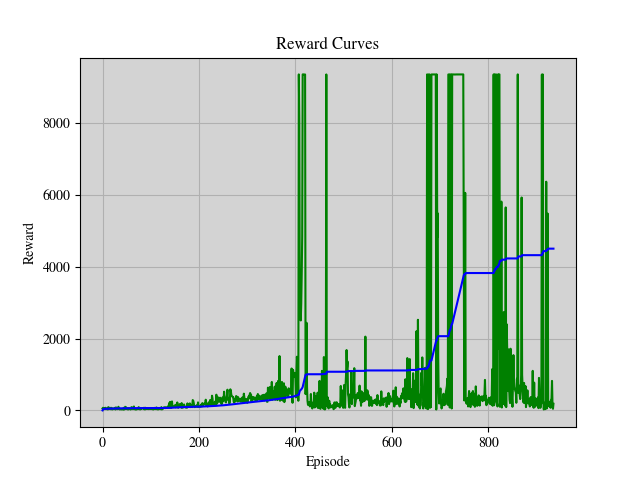

<Figure size 640x480 with 0 Axes>

In [ ]:
trainer.strategy._lightning_module.reward_curve()

## **Inference**

In [ ]:
def animate_agent(env, agent, output, dir=EXPERIMENT_DIR):
    obs, _ = env.reset(seed=SEED)
    while True:
        obs = torch.tensor(obs).float().unsqueeze(0).to(DEVICE)
        action = agent(obs)
        obs, _, terminated, truncated, _ = env.step(action)

        done = terminated or truncated
        if done:
            break

    env.close()
    del env

    path = glob.glob(os.path.join(dir, "*.mp4"))[0]
    if output == "html":
        mp4 = open(path, "rb").read()
        url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return HTML(
            """<video width=400 controls><source src="%s" type="video/mp4"></video>""" % url
        )
    elif output == "gif":
        filename = os.path.join(dir, "agent.gif")
        videoClip = VideoFileClip(path)
        videoClip.write_gif(filename)
        with open(filename, "rb") as f:
            display(Image(data=f.read(), format="gif"))
    else:
        raise ValueError("Invalid output type")

In [ ]:
CONFIG[
    f"{ENVIRONMENT_NAME.split('-')[0]}Agent"
] = AgentModule.load_from_checkpoint(BEST_MODEL_PATH)
if DEVICE == "cuda":
    CONFIG[
    f"{ENVIRONMENT_NAME.split('-')[0]}Agent"
] = CONFIG[
    f"{ENVIRONMENT_NAME.split('-')[0]}Agent"
].cuda()
CONFIG[
    f"{ENVIRONMENT_NAME.split('-')[0]}Agent"
].eval()

AgentModule(
  (actor): Actor(
    (policy): Sequential(
      (0): Linear(in_features=9, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (critic1): Critic(
    (q_value): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (critic2): Critic(
    (q_value): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (critic1_target): Critic(
    (q_value): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (

In [ ]:
AgentEnv = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")
AgentEnv = gym.wrappers.RecordVideo(
    AgentEnv,
    video_folder=EXPERIMENT_DIR,
    episode_trigger=lambda t: t % 10 == 0,
    disable_logger=True,
)
animate_agent(
    AgentEnv,
    CONFIG[
        f"{ENVIRONMENT_NAME.split('-')[0]}Agent"
    ],
    output="html",
)

MoviePy - Building file experiment/agent.gif with imageio.


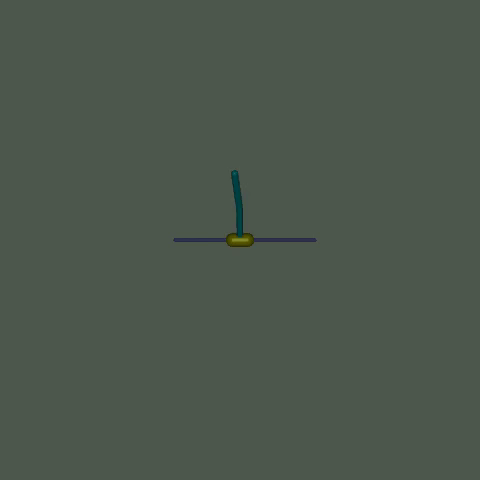

In [ ]:
AgentEnv = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")
AgentEnv = gym.wrappers.RecordVideo(
    AgentEnv,
    video_folder=EXPERIMENT_DIR,
    episode_trigger=lambda t: t % 10 == 0,
    disable_logger=True,
)
animate_agent(
    AgentEnv,
    CONFIG[
        f"{ENVIRONMENT_NAME.split('-')[0]}Agent"
    ],
    output="gif",
)